In [24]:
import numpy as np
import gc
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import string
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications.densenet import preprocess_input
# from keras.applications.resnet import preprocess_input

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')

**Load the descriptions** We are creating a dictionary with image name as the key and the reference captions in a list as the value

In [2]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:  
            continue
        img_id = token[0].split('.')[0] # name of the image
        img_des = token[1]              # description of the image
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping
  
token_path = '/content/drive/MyDrive/VR_Project/Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)

In [3]:
print(descriptions['1007129816_e794419615'])

['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']


**Cleaning the descriptions** (reference captions) : We are removing punctuations and special characters and converting it to lowercase.

In [4]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)


In [5]:
print(descriptions['1007129816_e794419615'])

['man in an orange hat starring at something', 'man wears an orange hat and glasses', 'man with gauges and glasses is wearing blitz hat', 'man with glasses is wearing beer can crocheted hat', 'the man with pierced ears is wearing glasses and an orange hat']


In [6]:
len(descriptions)

8092

In [7]:
images_path = "/content/drive/MyDrive/VR_Project/Flicker8k_Images"
train_path = '/content/drive/MyDrive/VR_Project/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/drive/MyDrive/VR_Project/Flickr8k_text/Flickr_8k.valImages.txt'
test_path = '/content/drive/MyDrive/VR_Project/Flickr8k_text/Flickr_8k.testImages.txt'

In [8]:
def load_set(filename):
    file = open(train_path, 'r')
    doc = file.read()
    dataset = list()

    for line in doc.split('\n'):

        if len(line) < 1:
            continue
# get the image identifier
        identifier = line.split('.')[0] #before the .jpg
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = train_path
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [9]:
img = glob.glob1(images_path , '*.jpg')
len(img)

8091

Creating list of train images

In [10]:
train_images = set(open(train_path, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [11]:
print(len(train_img))

6000


In [12]:
train_img[0]

'378453580_21d688748e.jpg'

In [13]:
test_images = set(open(test_path, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [14]:
len(test_img)

1000

In [15]:
test_img[0]

'3767841911_6678052eb6.jpg'

Caption Pre-Processing : we add ‘startseq’ at the beginning and ‘endseq’ at the end of the sentence to each caption. This is to help tell the model when it should start writing or stop predicting next word at training phase.

In [16]:
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'stseq ' + line + ' enseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [17]:
train_descriptions['1007129816_e794419615']

['stseq man in an orange hat starring at something enseq',
 'stseq man wears an orange hat and glasses enseq',
 'stseq man with gauges and glasses is wearing blitz hat enseq',
 'stseq man with glasses is wearing beer can crocheted hat enseq',
 'stseq the man with pierced ears is wearing glasses and an orange hat enseq']

In [18]:
import tensorflow as tf

**Using pretrained cnn model for feature extraction**

In [23]:
model = tf.keras.applications.DenseNet201(weights="imagenet")
# model = tf.keras.applications.ResNet50(weights="imagenet")

In [25]:
def preprocess(image_path):
    # Convert all the images to size 224x224 as expected by the densenet201 model
    # img = image.load_img(os.path.join(images_path,image_path), target_size=(224, 224))
    # Convert all the images to size 224x224 as expected by the Resnet50 model
    img = image.load_img(os.path.join(images_path,image_path), target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from densenet module
    x = preprocess_input(x)
    return x

In [26]:
model_new = Model(model.input, model.layers[-2].output) #removing last layer

In [27]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [28]:
# Function to encode a given image into a vector of size (1920, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 1920) to (1920, )
    return fea_vec

In [29]:
from tqdm import tqdm

In [ ]:
# start = time()
# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[:]] = encode(img)
# print("Time Taken is: " + str(time() - start))

In [31]:
# a_file = open("resnet_data.pkl", "wb")
# a_file = open("densenet_data.pkl", "wb")
# dump(encoding_train, a_file)
# a_file.close()

# a_file = open("/content/drive/MyDrive/VR_Project/resnet_data.pkl", "rb")
a_file = open("/content/drive/MyDrive/VR_Project/densenet_data.pkl", "rb")
encoding_train = load(a_file)

In [32]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [33]:
train_features = encoding_train

print("Train image encodings: " + str(len(train_features)))


Train image encodings: 6000


In [34]:
encoding_train['3226254560_2f8ac147ea.jpg'].shape

(1920,)

In [35]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [36]:
word_count_threshold = 5 #only words which occur atleast 4 times will be added to the vocabulary
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


we have to tokenize the captions from the train set and get the word-index & index-word dictionaries from that.
The wordtoix dictionary is meant to represent the captions as a number to be inputted to the model
The ixtoword is to convert the next word/prediction to the word form, as we know it.

In [37]:
# word mapping to integers
indextoword = {}
wordtoindex = {}

ix = 1
for w in vocab:
    wordtoindex[w] = ix
    indextoword[ix] = w
    ix += 1

In [38]:
vocab_size = len(indextoword) + 1 # one for none of these
vocab_size

2531

In [39]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [40]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoindex[word] for word in cap.split(' ') if word in wordtoindex]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(298088, 1920)


In [41]:
# Load Glove vectors
glove_dir = '/content/drive/MyDrive/VR_Project/glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoindex.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [43]:
embedding_matrix.shape

(2531, 200)

In [44]:
import gc

In [45]:
gc.collect()

58336

In [46]:
inputs1 = Input(shape=(X1.shape[1],))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [47]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      506200      input_5[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1920)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [48]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [50]:
gc.collect()

14425

In [51]:
model.fit([X1, X2], y, epochs = 30, batch_size = 256)

Epoch 1/30
1165/1165 [==============================] - 150s 123ms/step - loss: 4.7394
Epoch 2/30
1165/1165 [==============================] - 142s 122ms/step - loss: 3.4977
Epoch 3/30
1165/1165 [==============================] - 142s 122ms/step - loss: 3.2215
Epoch 4/30
1165/1165 [==============================] - 143s 122ms/step - loss: 3.0534
Epoch 5/30
1165/1165 [==============================] - 143s 122ms/step - loss: 2.9468
Epoch 6/30
1165/1165 [==============================] - 143s 122ms/step - loss: 2.8537
Epoch 7/30
1165/1165 [==============================] - 141s 121ms/step - loss: 2.7805
Epoch 8/30
1165/1165 [==============================] - 142s 122ms/step - loss: 2.7333
Epoch 9/30
1165/1165 [==============================] - 146s 125ms/step - loss: 2.6845
Epoch 10/30
1165/1165 [==============================] - 147s 126ms/step - loss: 2.6343
Epoch 11/30
1165/1165 [==============================] - 146s 125ms/step - loss: 2.6036
Epoch 12/30
1165/1165 [==================

In [52]:
def greedy_search(pic):
    start = 'stseq'
    for i in range(max_length):
        seq = [wordtoindex[word] for word in start.split() if word in wordtoindex]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat) # choosing the one with max probability
        word = indextoword[yhat]
        start += ' ' + word
        if word == 'enseq':
            break
    final = start.split()
    final = final[1:-1] # removing stseq and enseq from the prediction
    return final

In [53]:
def beam_search(pic,k):
  in_text='stseq'
  sequence = [wordtoindex[s] for s in in_text.split() if s in wordtoindex]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([pic,sequence])
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indextoword[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split()[-1]=="enseq":
        break
      sequence = [wordtoindex[s] for s in text[0].split() if s in wordtoindex]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([pic,sequence])
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indextoword[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  return final

Calculating Average Bleu Score on Test Set using Greedy Search

In [54]:
test_descriptions = load_clean_descriptions(descriptions, test_images)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [55]:
from nltk.translate.bleu_score import sentence_bleu

In [56]:
#Encode all the test images
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[:]] = encode(img)
print("Time taken is: " + str(time() - start))

100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s]

Time taken is: 151.62726974487305


In [57]:
test_features = encoding_test
print("Test image encodings: " + str(len(test_features)))

Test image encodings: 1000


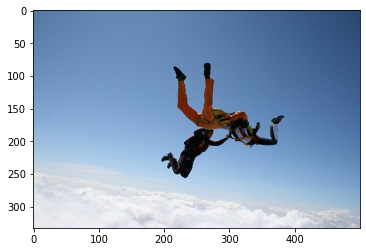

['man', 'is', 'hanging', 'on', 'top', 'of', 'cliff']


In [61]:
pic = list(encoding_test.keys())[240]
img = encoding_test[pic].reshape(1, X1.shape[1])
x = plt.imread(os.path.join(images_path ,pic))
plt.imshow(x)
plt.show()
print(beam_search(img,3))

In [62]:
import string

In [63]:
def blue_score(search_fun,param=None):
  i=0
  tot_score=0
  for img_id in tqdm(test_features):
      i+=1
      photo=test_features[img_id]
      img = photo.reshape(1, photo.shape[0])
      string1 = img_id[:-4]
      reference=[]
      for caps in test_descriptions[string1]:
          list_caps=caps.split(" ")
          list_caps=list_caps[1:-1]
          reference.append(list_caps)
      if(param==None):
          candidate=search_fun(img)
      else:
          candidate=search_fun(img,param)
      score = sentence_bleu(reference, candidate)
      tot_score+=score
  avg_score=tot_score/i
  return avg_score

In [64]:
print('The bleuscore over the test dataset with greedy search is: ',blue_score(greedy_search))

  0%|          | 1/1000 [00:00<10:33,  1.58it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 5/1000 [00:02<09:18,  1.78it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  2%|▏         | 16/1000 [00:09<09:06,  1.80it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [09:20<00:00,  1.79it/s]

The bleuscore over the test dataset with greedy search is:  0.5563663017733543


In [65]:
print('The bleuscore over the test dataset with beam search is: ',blue_score(beam_search,3))

  0%|          | 1/1000 [00:02<42:04,  2.53s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/1000 [00:06<36:19,  2.19s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  1%|          | 6/1000 [00:11<32:29,  1.96s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [32:44<00:00,  1.96s/it]

The bleuscore over the test dataset with beam search is:  0.5426693358743678


Testing on Subjective Images

In [66]:
def sub_preprocess(image_path):
    # Convert all the images to size 224x224 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [67]:
def sub_encode(image):
    image = sub_preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 1920) to (1920, )
    return fea_vec

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


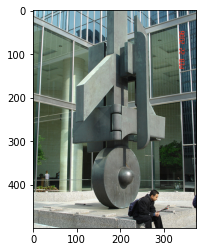

man in black shirt is standing on the sidewalk with his back to the camera
man is sitting on bench next to fancy sculpture


In [68]:
img_path = '/content/drive/MyDrive/VR_Project/subjective_img/sample1.jpg'
sample = sub_encode(img_path)
img = sample.reshape(1, sample.shape[0])
x = plt.imread(img_path ,sample)
plt.imshow(x)
plt.show()
final1 = greedy_search(img)
final1 = " ".join(final1)
final2 = beam_search(img,3)
final2 = " ".join(final2)
print(final1)
print(final2)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


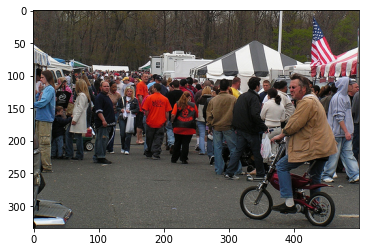

man in black and white biking gear is kneeling on the sidewalk
group of people are riding bicycles on the street


In [69]:
img_path = '/content/drive/MyDrive/VR_Project/subjective_img/sample2.jpg'
sample = sub_encode(img_path)
img = sample.reshape(1, sample.shape[0])
x = plt.imread(img_path ,sample)
plt.imshow(x)
plt.show()
final1 = greedy_search(img)
final1 = " ".join(final1)
final2 = beam_search(img,3)
final2 = " ".join(final2)
print(final1)
print(final2)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


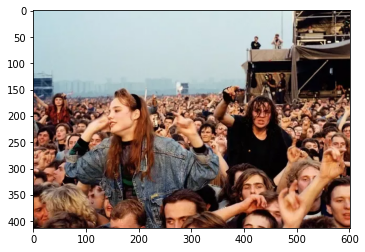

group of people are gathered around building
group of people are gathered in front of fountain


In [70]:
img_path = '/content/drive/MyDrive/VR_Project/subjective_img/sample3.jpg'
sample = sub_encode(img_path)
img = sample.reshape(1, sample.shape[0])
x = plt.imread(img_path ,sample)
plt.imshow(x)
plt.show()
final1 = greedy_search(img)
final1 = " ".join(final1)
final2 = beam_search(img,3)
final2 = " ".join(final2)
print(final1)
print(final2)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


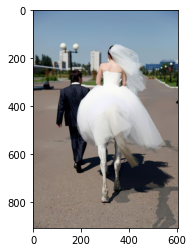

two dogs are playing with ball
two dogs are playing with ball


In [71]:
img_path = '/content/drive/MyDrive/VR_Project/subjective_img/sample4.jpg'
sample = sub_encode(img_path)
img = sample.reshape(1, sample.shape[0])
x = plt.imread(img_path ,sample)
plt.imshow(x)
plt.show()
final1 = greedy_search(img)
final1 = " ".join(final1)
final2 = beam_search(img,3)
final2 = " ".join(final2)
print(final1)
print(final2)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


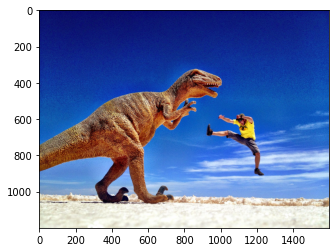

man in black shorts and hat is standing on rock with his legs spread wide open
man is standing on rock with his hands in the air


In [72]:
img_path = '/content/drive/MyDrive/VR_Project/subjective_img/sample5.jpg'
sample = sub_encode(img_path)
img = sample.reshape(1, sample.shape[0])
x = plt.imread(img_path ,sample)
plt.imshow(x)
plt.show()
final1 = greedy_search(img)
final1 = " ".join(final1)
final2 = beam_search(img,3)
final2 = " ".join(final2)
print(final1)
print(final2)

Saving the model

In [73]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      506200      input_5[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1920)         0           input_4[0][0]                    
____________________________________________________________________________________________